Author:
John P. Powers

Copyright and licensing:
© 2024, The University of North Carolina at Chapel Hill. Permission is granted to use in accordance with the MIT license. 

The code is licensed under the open-source MIT license.

The following code is intended as a demonstration of a Python script in the form of a Jupyter notebook.  
This demonstration includes: 
- The general structure and workflow of a data science script
- Using Markdown for structure, annotation, and improved readability
- Examples of a variety of basic Python coding tasks, such as importing code, loading data, using Pandas to explore and manipulate data, and using seaborn and matplotlib to visualize data
- An example of creating, running, and interpreting results from a machine learning model 

This is an edited, simplified excerpt of code from a real, published project (https://doi.org/10.1080/13811118.2024.2436636).  
It uses a publicly available dataset, originally from https://osf.io/8mk6x/ (CC0 1.0 Universal license), which has been processed to prepare the simplified survey_dataset.csv provided with this demo.   
The data consist of survey responses from adolescents with elevated depression scores. Participants completed a battery of various psychological and experience measures.  
In this demo, the final goal is to create a model to predict whether an adolescent has ever engaged in non-suicidal self-injury using the demographic data and the data from the psychological and experience measures as predictors.  
Note, in the context of machine learning, the term target is often used to refer to the outcome variable, the term feature refers to a predictor variable, and the term sample refers to a row of data / participant / observation.

To run the following code, the requisite code packages need to be installed in your Python environment so that they can be imported as shown.  
Using conda to install pandas, seaborn, and scikit-learn should install all necessary code packages, including dependencies.  
Occasionally, code can break if relevant changes have been made to a package between the version the code was developed with and the version you are using to try to run the code.  
For reference, the following code was developed using the following package versions.
- matplotlib-base 3.10.0
- matplotlib-inline 0.1.7
- numpy 2.2.2
- pandas 2.2.3
- scikit-learn 1.6.1
- seaborn 0.13.2

# Setup and Preprocessing

## Load code and data

In [1]:
## Import code
# Basics and plotting
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_sample_weight

# Cross-validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Model performance evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Model feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# Load the dataset into a Pandas dataframe
# Note the CSV file must be in your current working directory for this command to work as written
# Otherwise, you need to adjust the filepath in the command to point to the folder where the CSV file is stored
data = pd.read_csv('survey_dataset.csv')

In [3]:
# Preview the first several rows
data.head()

,recorded_date,response_id,uls_tot,cdi_tot,dem_sex,dem_gender,dem_orientation,bads_tot,shs_tot,bhs_tot,aces_tot,mvps_tot,eds_events_tot,gad_tot,sitbi_2
0,2020-11-24,R_4SFlsyU22W6Ywpz,44.0,21.0,Female,Woman/Girl,Heterosexual/Straight,10.0,13.0,11.0,3.0,14.0,29.0,17.0,1.0
1,2020-11-21,R_d0653ES9MVJWi7n,33.0,14.0,Female,Woman/Girl,Bisexual,18.0,23.0,7.0,2.0,0.0,34.0,22.0,1.0
2,2020-11-28,R_r3FCy97x6xoH1yF,27.0,9.0,Male,Not sure,Queer,18.0,17.0,7.0,4.0,4.0,32.0,18.0,1.0
3,2020-11-20,R_26f4nfF2RAqA8Bz,44.0,11.0,Female,Woman/Girl,Heterosexual/Straight,20.0,26.0,7.0,4.0,5.0,23.0,20.0,0.0
4,2020-11-28,R_3ps8IafpWy15WHE,27.0,7.0,Female,Woman/Girl,Heterosexual/Straight,28.0,20.0,4.0,1.0,0.0,16.0,11.0,0.0


## Data reduction and exploration

This section includes reducing the dataset to variables of interest; renaming variables; listwise deletion for missing data on the target variable; recoding a categorical feature; and visualizing variable distributions, correlations, and interactions.

In [4]:
# Get general info about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recorded_date    2452 non-null   object 
 1   response_id      2452 non-null   object 
 2   uls_tot          2446 non-null   float64
 3   cdi_tot          2448 non-null   float64
 4   dem_sex          2452 non-null   object 
 5   dem_gender       2452 non-null   object 
 6   dem_orientation  2452 non-null   object 
 7   bads_tot         2448 non-null   float64
 8   shs_tot          2450 non-null   float64
 9   bhs_tot          2451 non-null   float64
 10  aces_tot         2447 non-null   float64
 11  mvps_tot         2447 non-null   float64
 12  eds_events_tot   2448 non-null   float64
 13  gad_tot          2447 non-null   float64
 14  sitbi_2          2451 non-null   float64
dtypes: float64(10), object(5)
memory usage: 287.5+ KB


In [5]:
# Reduce to columns of interest.
# In this example, these include 3 categorical demographic features:
# sex, gender, sexual orientation

# 9 numeric features of total scores on psychological scales:
# UCLA Loneliness scale
# Children's Depression Inventory 2-Short Form
# Generalized Anxiety Disorder 7
# Behavioral Activation for Depression Scale-Short Form
# State Hope Scale
# Beck Hopelessness Scale 4
# Adverse Childhood Experiences Questionnaire
# Multidimensional Peer Victimization Scale
# Expanded Everyday Discrimination Scale

# and 1 binary target variable indicating whether the person has ever engaged in non-suicidal self-injury
# from the Self-Injurious Thoughts and Behaviors Interview-Short Form

data = data[['uls_tot', 'cdi_tot', 'dem_sex', 'dem_gender', 'dem_orientation', 
             'bads_tot', 'shs_tot' , 'bhs_tot', 'aces_tot' , 'mvps_tot', 
             'eds_events_tot', 'gad_tot', 'sitbi_2']]

# Check the results
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uls_tot          2446 non-null   float64
 1   cdi_tot          2448 non-null   float64
 2   dem_sex          2452 non-null   object 
 3   dem_gender       2452 non-null   object 
 4   dem_orientation  2452 non-null   object 
 5   bads_tot         2448 non-null   float64
 6   shs_tot          2450 non-null   float64
 7   bhs_tot          2451 non-null   float64
 8   aces_tot         2447 non-null   float64
 9   mvps_tot         2447 non-null   float64
 10  eds_events_tot   2448 non-null   float64
 11  gad_tot          2447 non-null   float64
 12  sitbi_2          2451 non-null   float64
dtypes: float64(10), object(3)
memory usage: 249.2+ KB


In [6]:
# Rename columns to more intuitive names
data.rename(columns = {'uls_tot':'loneliness', 'cdi_tot':'depression', 'dem_sex':'sex',
                        'dem_gender':'gender', 'dem_orientation':'orientation', 'bads_tot':'behav_act',
                        'shs_tot':'hope', 'bhs_tot':'hopelessness', 'aces_tot':'child_adverse',
                        'mvps_tot':'peer_vict', 'eds_events_tot':'discrimination', 
                        'gad_tot':'anxiety', 'sitbi_2':'nssi_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2446 non-null   float64
 1   depression      2448 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2448 non-null   float64
 6   hope            2450 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2447 non-null   float64
 9   peer_vict       2447 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
dtypes: float64(10), object(3)
memory usage: 249.2+ KB


In [7]:
# Get missing data counts for each column
data.isnull().sum()

loneliness        6
depression        4
sex               0
gender            0
orientation       0
behav_act         4
hope              2
hopelessness      1
child_adverse     5
peer_vict         5
discrimination    4
anxiety           5
nssi_bin          1
dtype: int64

In [8]:
# We can see one sample (aka row, participant) is missing nssi_bin, the outcome variable.
# Perform listwise deletion of samples missing nssi_bin.
data = data[data['nssi_bin'].notna()]

# See new size of the dataset (in rows and columns)
# Can compare to results from data.info() above and confirm 1 less row.
data.shape

(2451, 13)

In [9]:
# How many unique values are contained in each column?
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

58 unique values in column loneliness
26 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
52 unique values in column behav_act
44 unique values in column hope
14 unique values in column hopelessness
7 unique values in column child_adverse
34 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin


In [10]:
# Gender was a select all that apply item.
# We want to reduce to a smaller number of mutually exclusive categories for gender.
# Look at current gender values and how many times they occur.
data['gender'].value_counts()

gender
Woman/Girl                                                                                                                         1383
Man/Boy                                                                                                                             194
Nonbinary                                                                                                                           138
Not sure                                                                                                                             78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                                        71
                                                                                                                                   ... 
Man/Boy,Trans female/Trans feminine                                                                                                   1
Two-spirited                             

In [11]:
# Recode gender values into 3 mutually exclusive categories.
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [12]:
# Verify recoding results
data['gender'].value_counts()

gender
woman_only        1383
gender_diverse     874
man_only           194
Name: count, dtype: int64

### Features: numeric

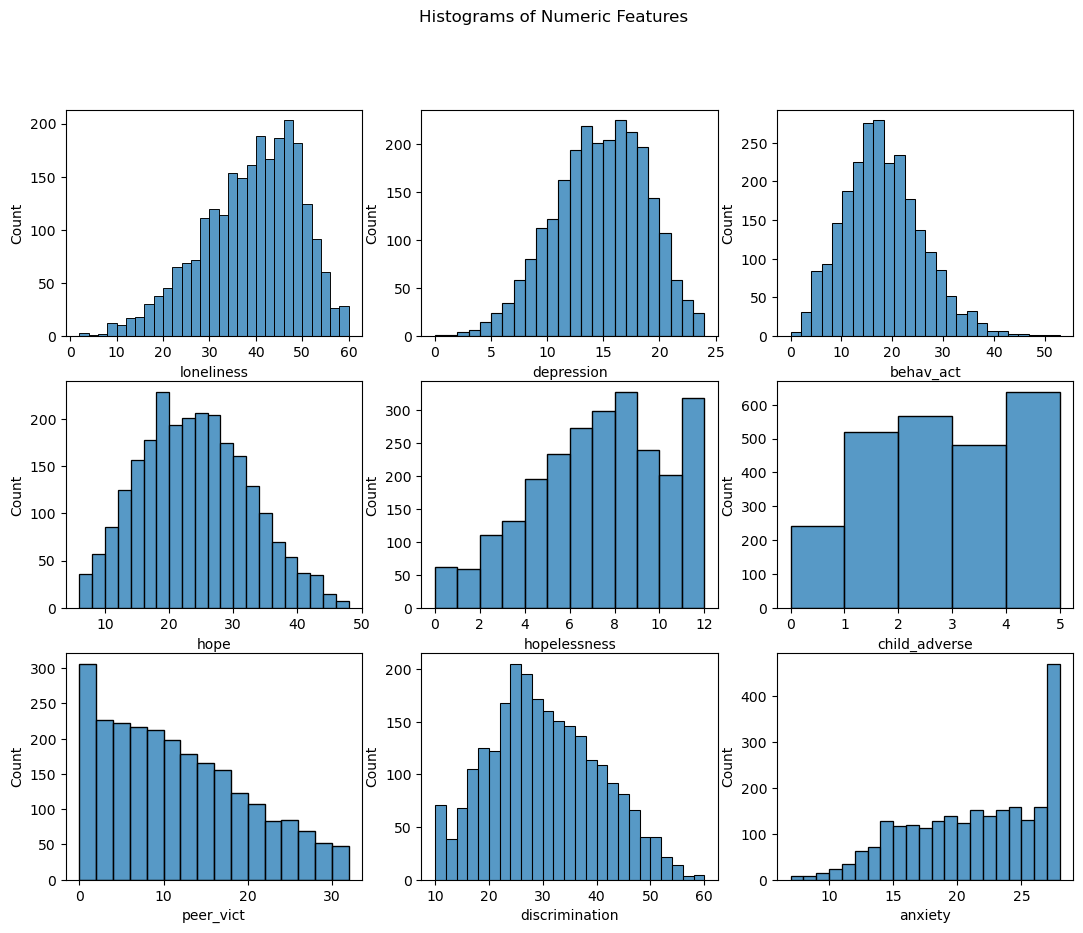

In [13]:
# Get histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'], binwidth=2)
sns.histplot(ax=axes[0, 1], data=data['depression'], binwidth=1)
sns.histplot(ax=axes[0, 2], data=data['behav_act'], binwidth=2)
sns.histplot(ax=axes[1, 0], data=data['hope'], binwidth=2)
sns.histplot(ax=axes[1, 1], data=data['hopelessness'], binwidth=1)
sns.histplot(ax=axes[1, 2], data=data['child_adverse'], binwidth=1)
sns.histplot(ax=axes[2, 0], data=data['peer_vict'], binwidth=2)
sns.histplot(ax=axes[2, 1], data=data['discrimination'], binwidth=2)
sns.histplot(ax=axes[2, 2], data=data['anxiety'], binwidth=1)

# Don't show unnecessary output about object
None

In [14]:
# Examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

,loneliness,depression,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
loneliness,1.000000,0.550011,-0.478647,-0.423158,0.508124,0.225473,0.272284,0.347911,0.380203
depression,0.550011,1.000000,-0.643446,-0.563095,0.634688,0.302187,0.322832,0.433894,0.564212
behav_act,-0.478647,-0.643446,1.000000,0.580059,-0.531347,-0.283846,-0.244080,-0.334728,-0.440418
hope,-0.423158,-0.563095,0.580059,1.000000,-0.594862,-0.189588,-0.175221,-0.238655,-0.274598
hopelessness,0.508124,0.634688,-0.531347,-0.594862,1.000000,0.172272,0.268169,0.340686,0.415289
child_adverse,0.225473,0.302187,-0.283846,-0.189588,0.172272,1.000000,0.263421,0.341760,0.268789
peer_vict,0.272284,0.322832,-0.244080,-0.175221,0.268169,0.263421,1.000000,0.625618,0.342707
discrimination,0.347911,0.433894,-0.334728,-0.238655,0.340686,0.341760,0.625618,1.000000,0.421275
anxiety,0.380203,0.564212,-0.440418,-0.274598,0.415289,0.268789,0.342707,0.421275,1.000000


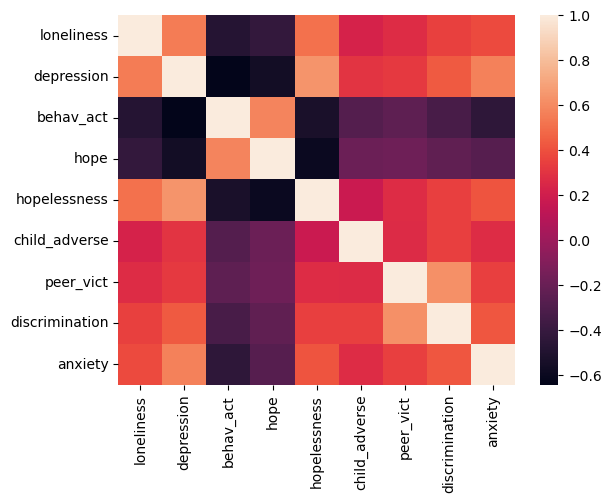

In [15]:
# Get a heatmap of these correlations
sns.heatmap(data[numeric_features].corr())
None

We can see some expected relationships.   
Strong correlations between loneliness, hopelessness, depression, and anxiety  
These tend to be inversely related to behavioral activation and hope.  
Also strong correlation between discrimination and peer victimization  

### Features: categorical

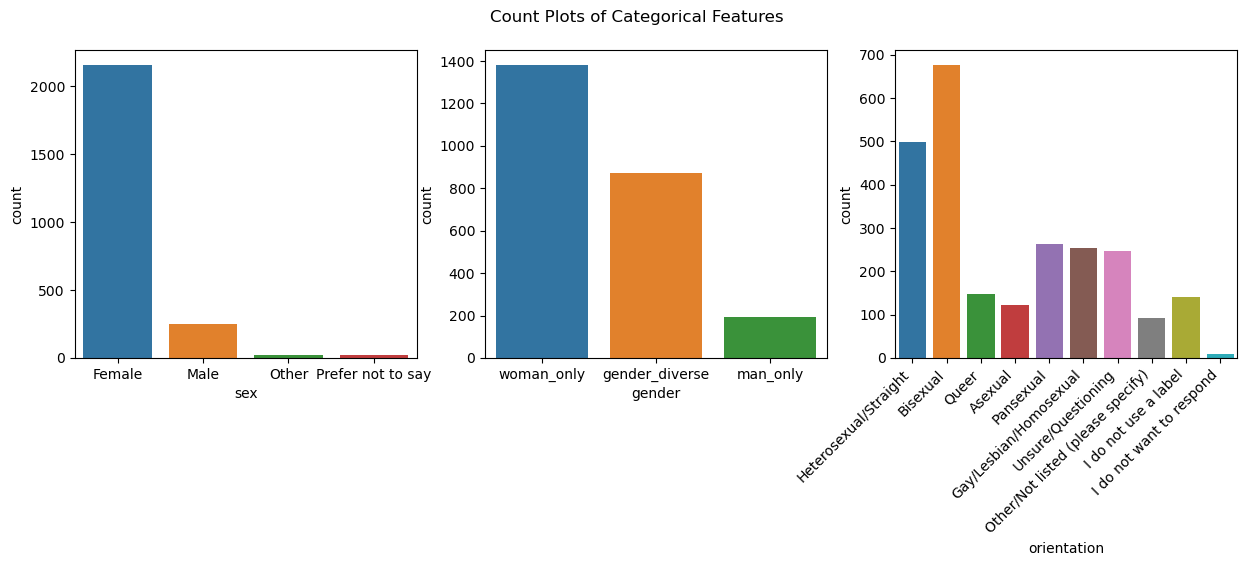

In [16]:
# Get count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'], hue=data['sex'], legend=False)

sns.countplot(ax=axes[1], x=data['gender'], hue=data['gender'], legend=False)

sns.countplot(ax=axes[2], x=data['orientation'], hue=data['orientation'], legend=False)

plt.xticks(rotation=45, horizontalalignment='right')
None

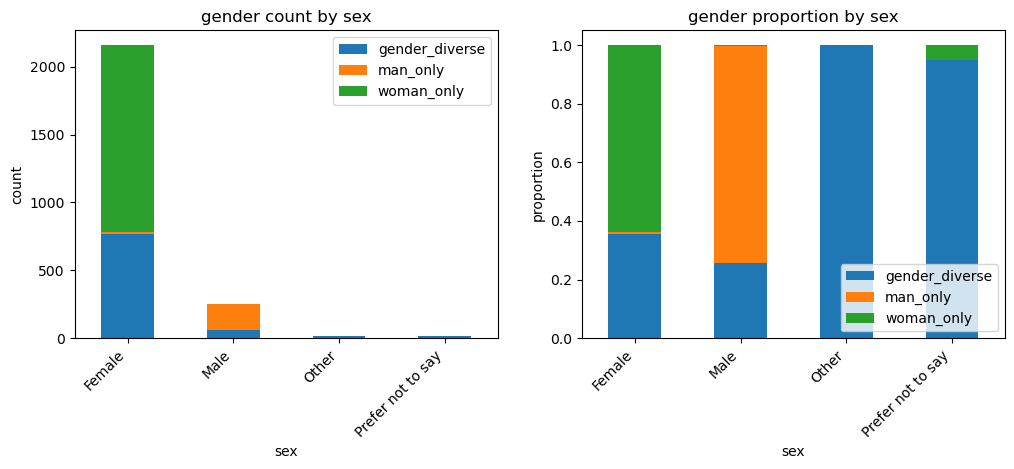

In [17]:
# Examine distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

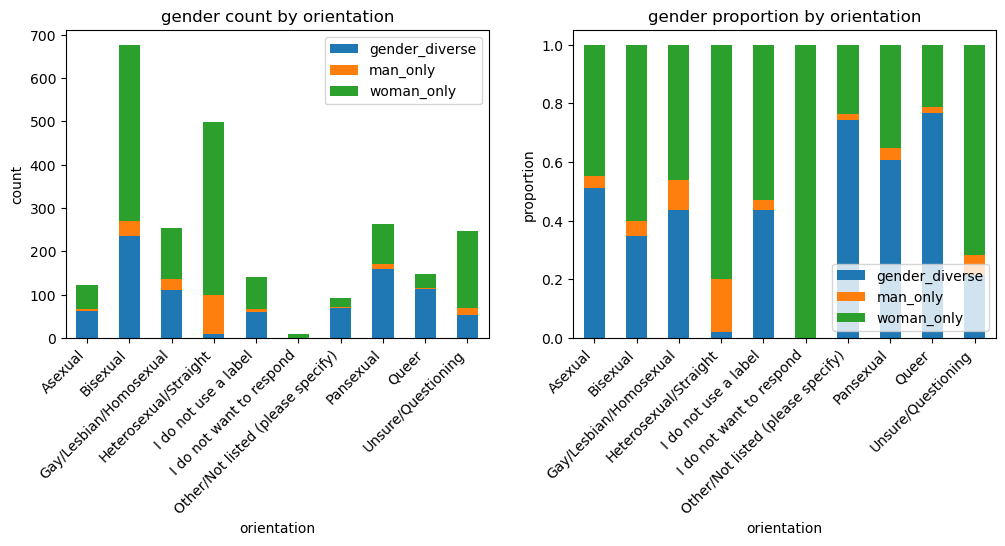

In [18]:
# Examine distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

These plots help to demonstrate that each of these demographic features contributes unique information.

### Target

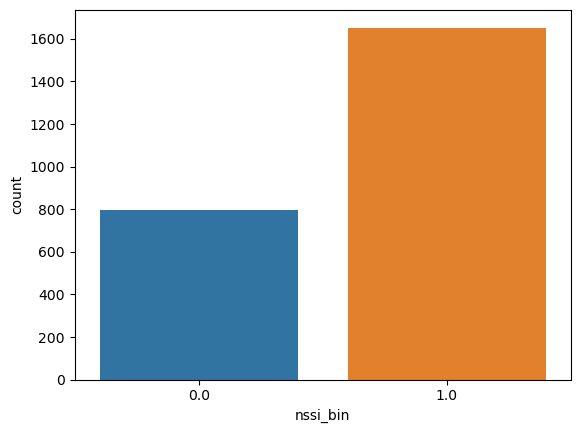

In [19]:
# Get count plot of categorical target variable
sns.countplot(x=data['nssi_bin'], hue=data['nssi_bin'], legend=False)
None

We can see the dataset is imbalanced. There are more positive than negative responses on the outcome variable.

# Modeling

This section includes creating a machine learning model, specifically a random forest model, to predict the outcome variable from the demographic and psychological features.  
Steps include additional preprocessing, missing data imputation, and setting model hyperparameters.

In [20]:
# Define target
target = data['nssi_bin']

# Define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# Specifically define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# Define imputer for imputing missing data in numeric features
imputer = KNNImputer(n_neighbors=5)

# Define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

## Random forest

In [21]:
# Define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# Define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# Assemble steps into pipeline
rfc_pipeline = make_pipeline(preprocessor, imputer, rfc)

In [22]:
# Tuning model hyperparameters would be a logical next step at this point.
# To simplify this example, we're not showing this process here. 
# Instead, we're just setting the hyperparameters to the values we would have arrived at through tuning. 
rfc_pipeline.set_params(randomforestclassifier__max_leaf_nodes=256)
rfc_pipeline.set_params(randomforestclassifier__n_estimators=200)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  Index(['sex', 'gender', 'orientation'], dtype='object'))])),
                ('knnimputer', KNNImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_leaf_nodes=256, n_estimators=200,
                                        n_jobs=2, random_state=0))])

In [23]:
# Evaluate performance of the tuned model using cross-validation
rfc_results = cross_validate(rfc_pipeline, features, target, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.717 +/- 0.008
The mean precision with cross-validation is: 0.753 +/- 0.007
The mean recall with cross-validation is: 0.863 +/- 0.003
The mean AUROC with cross-validation is: 0.721 +/- 0.013


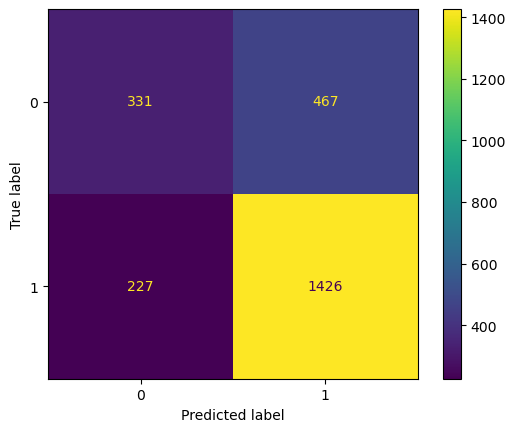

In [24]:
# Generate a confusion matrix showing counts for how often the model was able to learn 
# to correctly predict the outcome from the features vs. making false positive or negative errors.
rfc_preds = cross_val_predict(rfc_pipeline, features, target, cv=cross_val)
conf_mat = confusion_matrix(target, rfc_preds)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

# Interpretation

This section includes computing and visualizing permutation feature importance.  
This allows us to see the relative contributions of the different features to the model,  
i.e., which features the model has learned to use to make its predictions. 

## Permutation feature importance

In [25]:
# Define a function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=20):
    
    # Create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n))
    
    for i in range(perm_n):

        # Split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # Permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring='roc_auc', n_repeats=5, n_jobs=2, random_state=0)

        # Store results to the dataframe
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # Summarize results over the perm_n iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [26]:
# Call our function to compute the permutation feature importances
# Note this can take a couple minutes to run
# We are re-training the random forest model perm_n times on different train-test data splits
# For each trained model, we are then trying 5 different random shufflings of each feature in the test data,
# one feature at a time, and computing the loss in AUROC that results from this random shuffling vs. when the feature is intact.
rfc_importance_full, rfc_importance_summary = perm_feat_imp(rfc_pipeline)    

                    mean       std
depression      0.040726  0.008774
gender          0.019718  0.004658
child_adverse   0.018137  0.005384
discrimination  0.014724  0.005304
anxiety         0.008224   0.00491
peer_vict       0.005856  0.005691
orientation     0.005345  0.004114
behav_act       0.005294  0.005142
sex             0.004085  0.002413
hope            0.002109  0.004513
loneliness      0.002047  0.004353
hopelessness    0.001864  0.004346


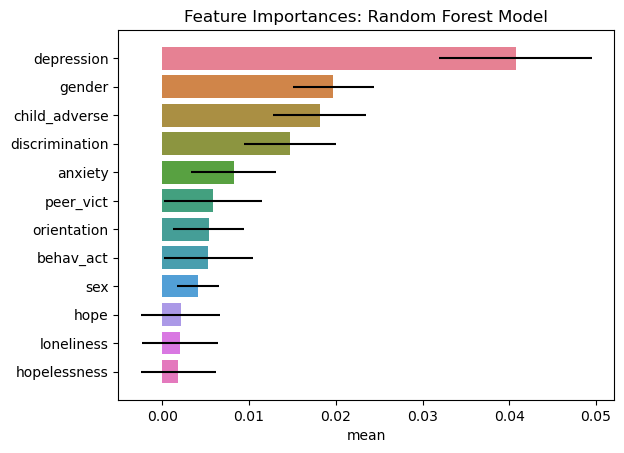

In [27]:

# Visualize the results
print(rfc_importance_summary)
plt.title("Feature Importances: Random Forest Model")
plot = sns.barplot(x=rfc_importance_summary['mean'], y=rfc_importance_summary.index, hue=rfc_importance_summary.index)
plt.errorbar(rfc_importance_summary['mean'], rfc_importance_summary.index, 
             xerr=rfc_importance_summary['std'], fmt='none', c='black')
plt.ylabel(None)

None

Mean indicates the mean loss in AUROC that results from randomly shuffling the feature in the test data.  
These results indicate that depression has the strongest influence on the model's predictions of ever engaging in non-suicidal self-injury in these adolescents, followed by gender identity, childhood adversity, and discrimination.